***In20-S4-CS3111 - Introduction to Machine Learning*** <br>
**K.S. RANASINGHE**<br>
**210518H**

#  Lab 01 - Feature Engineering



### Background
Feature engineering refers to the process of using domain knowledge to select and transform the most relevant variables from raw data when creating a predictive model using machine learning or statistical modeling. The goal of feature engineering and selection is to improve the performance of machine learning (ML) algorithms. Data preprocessing is an important step in the data mining process. It refers to the cleaning, transforming, and integrating of data in order to make it ready for analysis. The goal of data pre-processing is to improve the quality of the data. The objective of this task is to explore various data processing and feature engineering techniques to develop the best prediction machine learning model.

First, we import the required libraries




In [1]:
import pandas as pd
import numpy as np

#we are using the SimpleImputer to fill missing values because using a more complex method 
#can be too computationally intensive since we are dealing with a large dataset.
from sklearn.impute import SimpleImputer

#we are using the Ordinal Encoder to encode categorical values since some features can take
#a variety of values which would not be suitable for applying One Hot Encoding
from sklearn.preprocessing import OrdinalEncoder

#we could go with Normalization or Standardization here but we decided with Standardization 
#because it would help us in the future when we come to Feature Selection
from sklearn.preprocessing import StandardScaler

#libraries given below are used in the process of Feature Selection. we are using RFE
#algorithm for feature selection. I used SelectKBest as well but RFE performed better 
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

#we can use Principal Component Analysis on top of the selected feature set to further reduce the 
#number of features
from sklearn.decomposition import PCA

#here we are importing the packages for using the XGBoost Classifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

#finally using Shapley to intepret the developed model
import shap

### Data Loading

You have been provided with a loan default prediction data set from a finance company in the United States. The data provided contain information on previous loan applicants and whether they ‘defaulted’ or not. The aim is to identify patterns that indicate if a person is likely to default, which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc. Features, also known as variables, include credit scores, the quantity of financing queries, address details such as zip codes and states, and collections, among other factors. Details about the features are given in the data dictionary. The data set is a matrix of around 860,000 observations and 150 variables. Note that there are missing values, outliers, and features of multiple data types.

In [2]:
train_data = pd.read_csv("train.csv")
valid_data = pd.read_csv("valid.csv")
test_data = pd.read_csv("X_test.csv")

print('The shape of training dataset : ' + str(train_data.shape))
print('The shape of validating dataset : ' + str(valid_data.shape))
print('The shape of testing dataset : ' + str(test_data.shape))

The shape of training dataset : (517788, 145)
The shape of validating dataset : (172596, 145)
The shape of testing dataset : (172596, 144)


### Data Preprocessing

Data preprocessing is a vital step in a machine learning algorithm. We cannot use the model to predict anything if we have a incomplete dataset. That is where preprocessing comes in. Through this step we are able to fill missing data, encode any categorical data and scale down the data values so that we can run them in the model without introducing any bais.

The dataset we are using here is also incomplete. By running the below code you can get a glimpse of the quality of the training dataset.

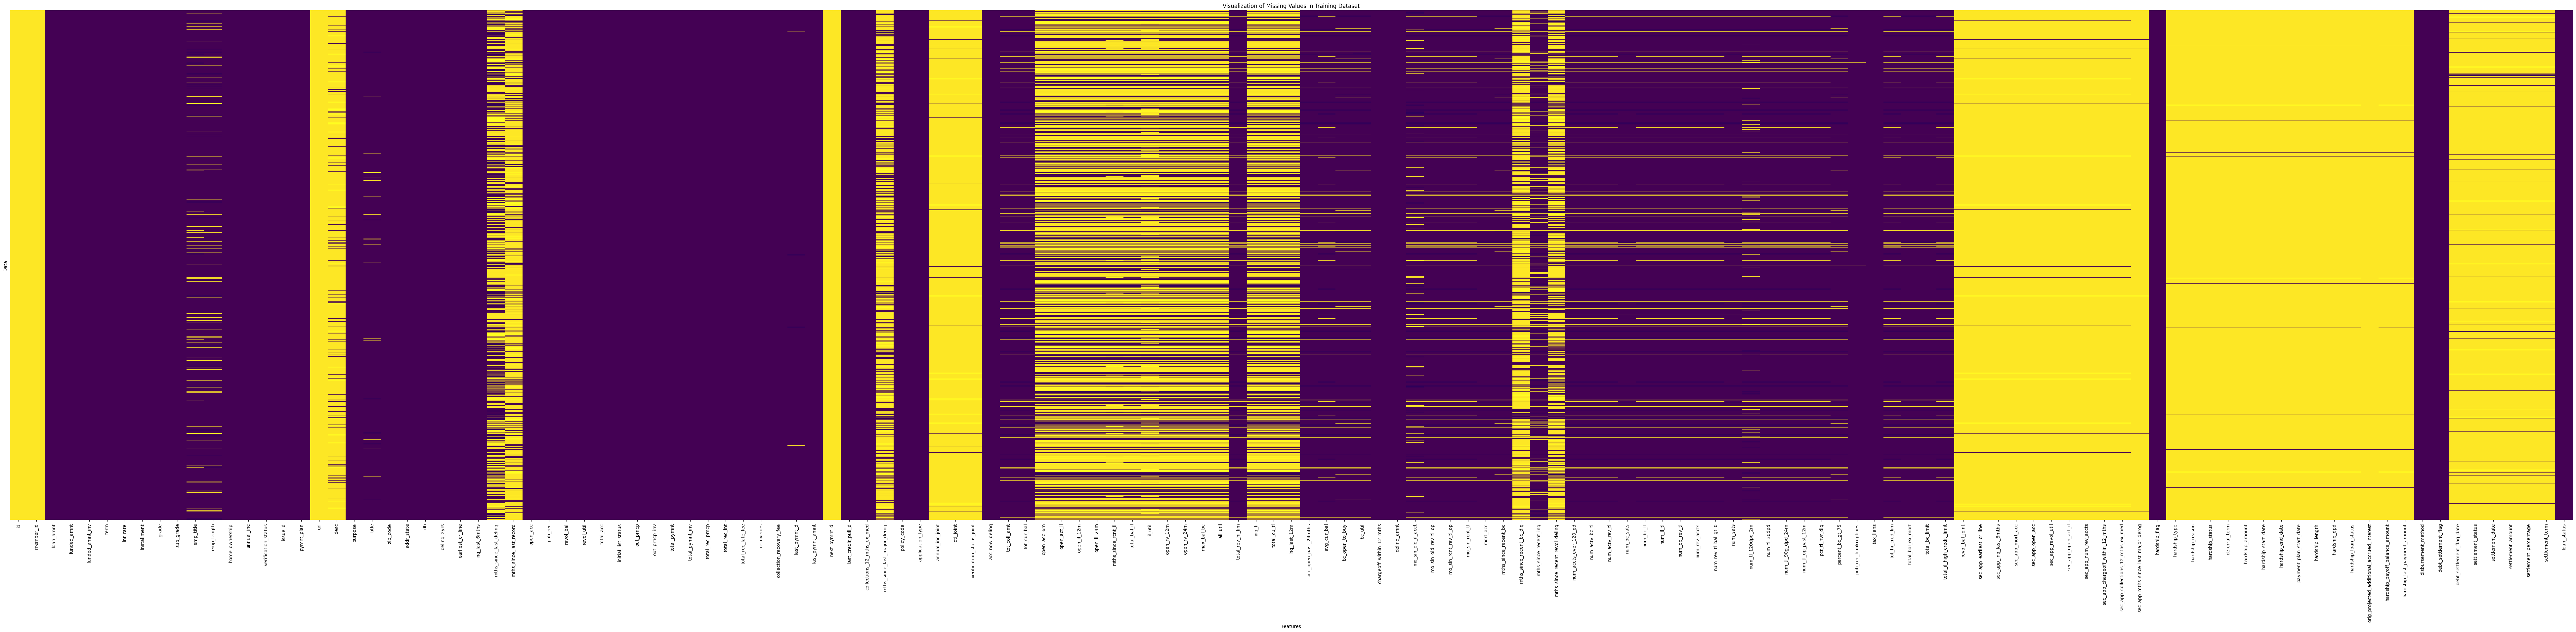

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap of missing values
plt.figure(figsize=(100,20))
sns.heatmap(train_data.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.xlabel('Features')
plt.ylabel('Data')
plt.title('Visualization of Missing Values in Training Dataset')
plt.show()


### Handling Missing Values

There are two ways that we employed in handling missing values. As you can see above from the heatmap there are features where most if not all of the data is missing. We cannot use Imputation techniques on such features as that could add a bias to the dataset since we cannot predict the performance of a feature with so little data.
<br>In our dataset we will be removing the features with more than 50% of the data missing. You could change the value for 'threshold_percentage' in the below code block and see how many features are retained.

In [4]:
threshold_percentage = 50

# Calculate the number of missing values for each column
missing_val_count_by_column = train_data.isnull().sum()

# Calculate the percentage of missing values for each column
percentage_missing = (missing_val_count_by_column / len(train_data)) * 100

# Identify columns exceeding the threshold percentage
columns_to_drop = percentage_missing[percentage_missing > threshold_percentage].index

# Remove columns exceeding the threshold percentage
train_filtered = train_data.drop(columns=columns_to_drop)
print("Shape of training dataset after removing columns with more than {}% missing values:".format(threshold_percentage))
print(train_filtered.shape)

Shape of training dataset after removing columns with more than 50% missing values:
(517788, 87)


By running the code block given below you could visualize the dataset after removing the features with large number of missing values.

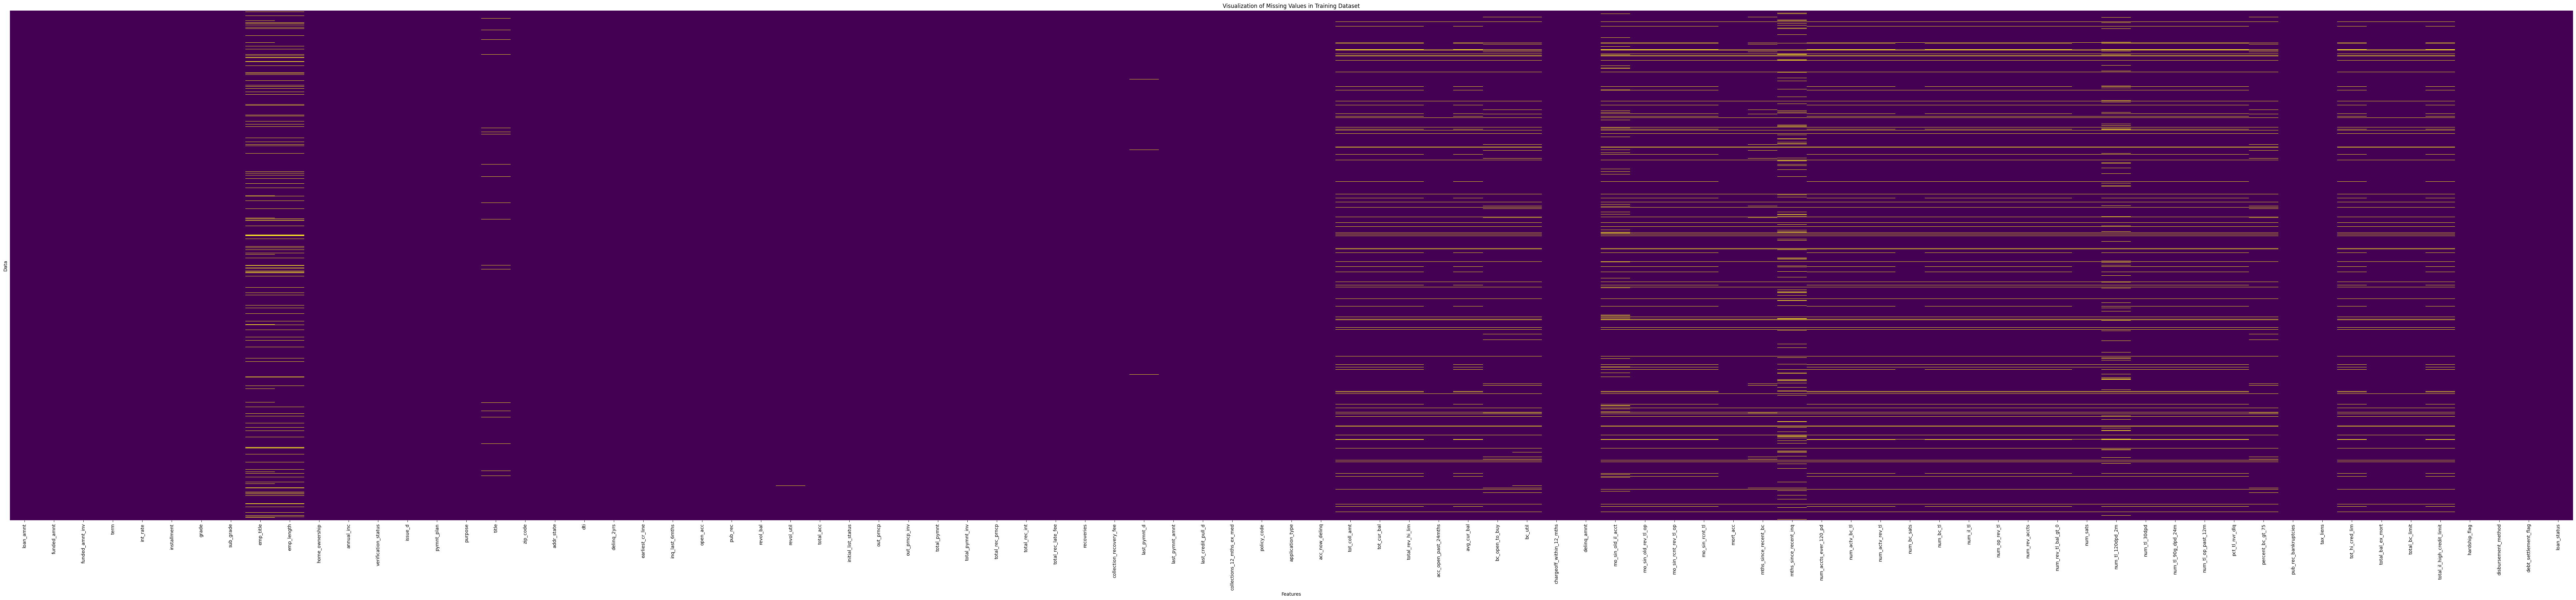

In [5]:
plt.figure(figsize=(100,20))
sns.heatmap(train_filtered.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.xlabel('Features')
plt.ylabel('Data')
plt.title('Visualization of Missing Values in Training Dataset')
plt.show()

Now that we have removed the features which we surely cannot use, lets complete our dataset. We are using the simple imputer to fill the missing data. But we broke down the set of features into categorical and numerical so that we could use the best imputation parameters for each. For numerical features we are using the mean and for categorical features we are using the most frequent value to fill missing data.

In [6]:
# Identify numerical and categorical columns with missing values
numeric_columns = train_filtered.select_dtypes(include='number').columns
categorical_columns = train_filtered.select_dtypes(exclude='number').columns

numeric_columns_with_missing_values = [col for col in numeric_columns if train_filtered[col].isnull().any()]
categorical_columns_with_missing_values = [col for col in categorical_columns if train_filtered[col].isnull().any()]

# imputation strategies for numerical and categorical columns
numeric_imputer = SimpleImputer(strategy='mean')  # Impute missing values with mean for numerical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')  # Impute missing values with most frequent category for categorical columns

# Apply imputation to fill missing values for numerical columns
train_imputed_numeric = train_filtered.copy()
train_imputed_numeric[numeric_columns_with_missing_values] = numeric_imputer.fit_transform(train_filtered[numeric_columns_with_missing_values])

# Apply imputation to fill missing values for categorical columns
train_imputed_categorical = train_imputed_numeric.copy()
train_imputed_categorical[categorical_columns_with_missing_values] = categorical_imputer.fit_transform(train_imputed_numeric[categorical_columns_with_missing_values])

# Checking whether there are any more missing values
print("No. of Missing Data in Columns")
missing_val_count_by_column = (train_imputed_categorical.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])
print('The shape of training dataset : ' + str(train_imputed_categorical.shape))

No. of Missing Data in Columns
Series([], dtype: int64)
The shape of training dataset : (517788, 87)


### Feature Encoding

The dataset that have been provided to us contains a lot of features with categorical values. We cannot enter values like that to a machine learning model. Hence we have to convert these values into numerical. By running the code given below you can see how features contain categorical values.

In [7]:
print("Number of categorical variables:", len(categorical_columns))

Number of categorical variables: 21


We will be using the Ordinal Encoding technique for our dataset because after closely analyzing the dataset it was found that there are features which could take many categorical values. If we employ a technique like One Hot Encoding here the number of columns would increase drastically with it the computational complexity.

In [8]:
s = (train_imputed_categorical.dtypes == 'object')
object_cols = list(s[s].index)

ordinal_encoder = OrdinalEncoder()
train_encoded = train_imputed_categorical.copy()
train_encoded[object_cols] = ordinal_encoder.fit_transform(train_imputed_categorical[object_cols])

print("Given below is the first few values of the column 'emp_length' which was previously categorical")
print(train_encoded.emp_length.head())
print('The shape of training dataset : ' + str(train_encoded.shape))

Given below is the first few values of the column 'emp_length' which was previously categorical
0     0.0
1     1.0
2     4.0
3     1.0
4    10.0
Name: emp_length, dtype: float64
The shape of training dataset : (517788, 87)


Another thing that is noticable after doing all this is that there exists features with zero variance across the dataset. That means all the rows for the feature contains the same value. These features are redundant as they cannot help us in predicting anything and adds a computational complexity as we still have to process them every time for no reason. So lets remove these features from the dataset.

In [9]:
# Check for columns with zero variance (i.e., all values are the same)
columns_to_drop = train_encoded.columns[train_encoded.nunique() == 1]

# Drop the columns with zero variance
train_encoded.drop(columns=columns_to_drop, inplace=True)
print('The shape of training dataset : ' + str(train_encoded.shape))

The shape of training dataset : (517788, 82)


### Feature Scaling

We will be using Standardization for scaling the dataset. There is no particular reason for choosing this over Normalization except that the data would be more spread out in Standardization compared to the other.


In [10]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_encoded)

# Convert the scaled NumPy array back to a DataFrame
train_scaled_df = pd.DataFrame(train_scaled, columns=train_encoded.columns)
print(train_scaled_df.head())
print(train_scaled_df.shape)

   loan_amnt  funded_amnt  funded_amnt_inv     term  int_rate  installment  \
0  -0.066582    -0.065633        -0.062991 -0.59474 -1.283089    -0.029072   
1  -1.442736    -1.442414        -1.439415 -0.59474  0.557919    -1.420590   
2  -1.098698    -1.098218        -1.123984 -0.59474 -1.274852    -1.096838   
3   0.690304     0.691597         0.694042 -0.59474 -0.327577     0.925283   
4  -0.525300    -0.524560        -0.521799 -0.59474 -1.274852    -0.503095   

      grade  sub_grade  emp_title  emp_length  ...  percent_bc_gt_75  \
0 -1.392088  -1.243133   0.082624   -1.099041  ...         -1.305130   
1  0.877630   0.734216   0.882812   -0.781132  ...          1.537526   
2 -1.392088  -1.243133   1.486457    0.172596  ...         -1.305130   
3 -0.635515  -0.330510   0.882812   -0.781132  ...          0.116198   
4 -1.392088  -1.243133   0.596033    2.080052  ...         -0.594466   

   pub_rec_bankruptcies  tax_liens  tot_hi_cred_lim  total_bal_ex_mort  \
0             -0.358985 

Another reason behind choosing Standardization is we could apply Dimensionality Reduction techniques like Principal Component Analysis and reduce the number of features in the dataset which inturn would reduce the computational complexity. We will get to more on this later. Change the value for 'n_components' to see how many features are retained.

In [11]:
pca = PCA(n_components=0.95)  # Retain 95% of the variance

X_train = train_scaled_df.drop(columns=['loan_status'])
y_train = train_data['loan_status']

X_train_pca = pca.fit_transform(X_train)
X_train_pca_df = pd.DataFrame(X_train_pca)

print("Train data shape:", X_train_pca_df.shape)

Train data shape: (517788, 50)


### Feature Selection

Since we have a large number of features we have to reduce them before applying them to the model. We will be using Recursive Feature Elimination for feature selection. This is more computationally intensive compared algorithms like SelectKBest but this performed better during testing. Another thing to be determined is the number of features to be selected. 
<br>I tried it for different sizes of features and found 10 was a optimal number of features giving a good accuracy. Choosing even lesser number of features did give off a higher accuracy score here but having too little number of features can overshoot the predictions. Therefore I decided to go ahead with this number.

In [12]:
clf = XGBClassifier()

selector = RFE(estimator=clf, n_features_to_select=10) 
selector.fit(X_train, y_train)
selected_features = X_train.columns[selector.support_]
scores = cross_val_score(clf, selector.transform(X_train), y_train, cv=5, scoring='accuracy')
print(f"Number of features selected: 10, Selected features: {selected_features}")
print(f"Performance score: {np.mean(scores):.4f}")

Number of features selected: 10, Selected features: Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'installment',
       'total_rec_prncp', 'total_rec_late_fee', 'recoveries',
       'last_pymnt_amnt', 'debt_settlement_flag'],
      dtype='object')
Performance score: 0.9996


### Dimensionality Reduction

Using Dimensionality Reduction we could further reduce the number of features in our dataset while preserving as much information as possible. In here we will be using Principal Component Analysis as our technique. The number of features to extract is set to 4. 

In [13]:
pca = PCA(n_components=4)  # No. of features after applying PCA

X_train = train_scaled_df[selected_features]
X_train_pca = pca.fit_transform(X_train)
X_train_pca_df = pd.DataFrame(X_train_pca)
print("Train data shape:", X_train_pca_df.shape)

Train data shape: (517788, 4)


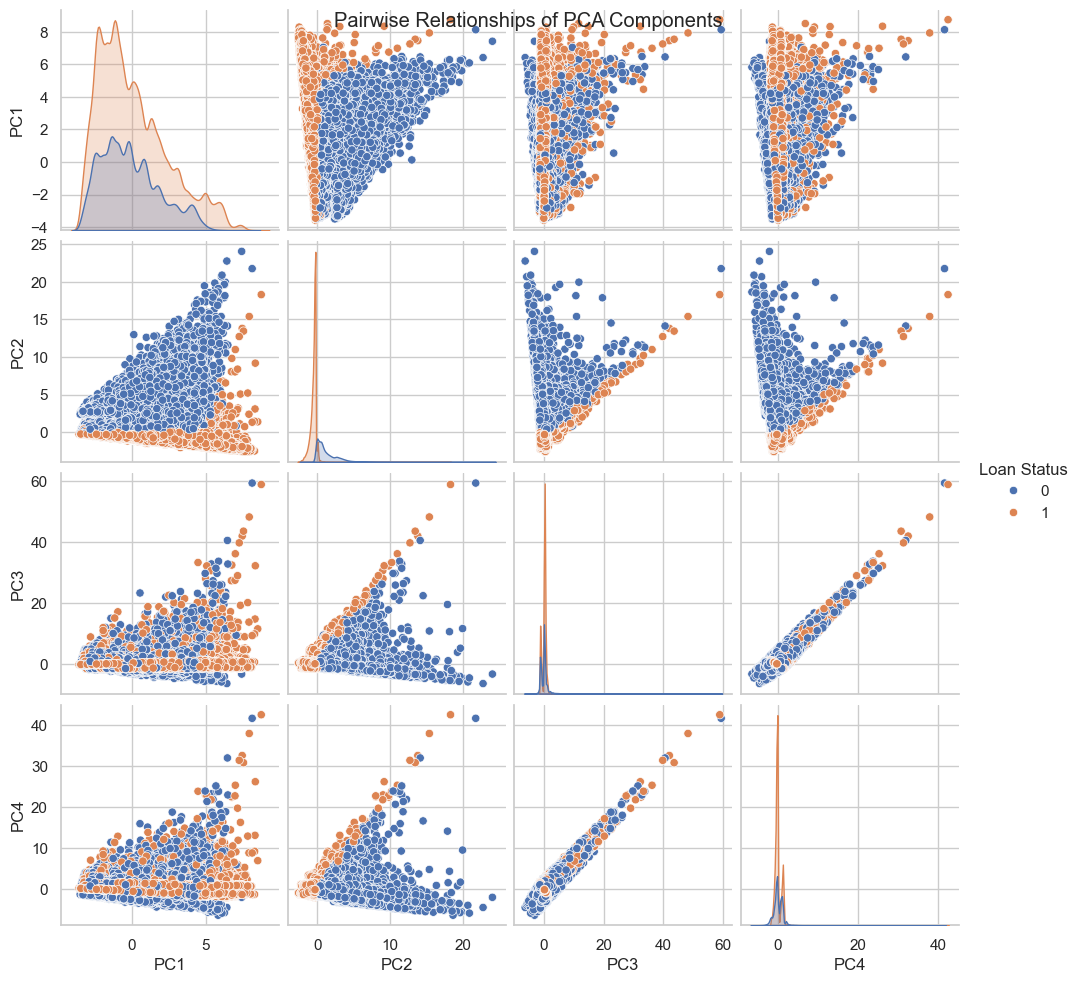

In [31]:
import seaborn as sns

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i}' for i in range(1, 5)])

# Add the target variable for coloring
pca_df['Loan Status'] = y_train

# Create a pairplot
sns.pairplot(pca_df, hue='Loan Status', diag_kind='kde')
plt.suptitle('Pairwise Relationships of PCA Components')
plt.show()



### Pre-processing Valid and Test Datasets

Now the feature engineering is complete. What is left is to do is to validate the model using a Classifier. But before that we need to repeat what we have done above for the validation and testing datasets.

In [14]:
# Filling Missing Values
threshold_percentage = 50
missing_val_count_by_column = valid_data.isnull().sum()
percentage_missing = (missing_val_count_by_column / len(valid_data)) * 100
columns_to_drop = percentage_missing[percentage_missing > threshold_percentage].index
valid_filtered = valid_data.drop(columns=columns_to_drop)

numeric_columns = valid_filtered.select_dtypes(include='number').columns
categorical_columns = valid_filtered.select_dtypes(exclude='number').columns
numeric_columns_with_missing_values = [col for col in numeric_columns if valid_filtered[col].isnull().any()]
categorical_columns_with_missing_values = [col for col in categorical_columns if valid_filtered[col].isnull().any()]
numeric_imputer = SimpleImputer(strategy='mean') 
categorical_imputer = SimpleImputer(strategy='most_frequent')
valid_imputed_numeric = valid_filtered.copy()
valid_imputed_numeric[numeric_columns_with_missing_values] = numeric_imputer.fit_transform(valid_filtered[numeric_columns_with_missing_values])
valid_imputed_categorical = valid_imputed_numeric.copy()
valid_imputed_categorical[categorical_columns_with_missing_values] = categorical_imputer.fit_transform(valid_imputed_numeric[categorical_columns_with_missing_values])

missing_val_count_by_column = test_data.isnull().sum()
percentage_missing = (missing_val_count_by_column / len(test_data)) * 100
columns_to_drop = percentage_missing[percentage_missing > threshold_percentage].index
test_filtered = test_data.drop(columns=columns_to_drop)

numeric_columns = test_filtered.select_dtypes(include='number').columns
categorical_columns = test_filtered.select_dtypes(exclude='number').columns
numeric_columns_with_missing_values = [col for col in numeric_columns if test_filtered[col].isnull().any()]
categorical_columns_with_missing_values = [col for col in categorical_columns if test_filtered[col].isnull().any()]
test_imputed_numeric = test_filtered.copy()
test_imputed_numeric[numeric_columns_with_missing_values] = numeric_imputer.fit_transform(test_filtered[numeric_columns_with_missing_values])
test_imputed_categorical = test_imputed_numeric.copy()
test_imputed_categorical[categorical_columns_with_missing_values] = categorical_imputer.fit_transform(test_imputed_numeric[categorical_columns_with_missing_values])

# Feature Encoding
s = (valid_imputed_categorical.dtypes == 'object')
object_cols = list(s[s].index)
ordinal_encoder = OrdinalEncoder()
valid_encoded = valid_imputed_categorical.copy()
valid_encoded[object_cols] = ordinal_encoder.fit_transform(valid_imputed_categorical[object_cols])
columns_to_drop = valid_encoded.columns[valid_encoded.nunique() == 1]
valid_encoded.drop(columns=columns_to_drop, inplace=True)

s = (test_imputed_categorical.dtypes == 'object')
object_cols = list(s[s].index)
test_encoded = test_imputed_categorical.copy()
test_encoded[object_cols] = ordinal_encoder.fit_transform(test_imputed_categorical[object_cols])
columns_to_drop = test_encoded.columns[test_encoded.nunique() == 1]
test_encoded.drop(columns=columns_to_drop, inplace=True)

# Feature Scaling
scaler = StandardScaler()
valid_scaled = scaler.fit_transform(valid_encoded)
valid_scaled_df = pd.DataFrame(valid_scaled, columns=valid_encoded.columns)

test_scaled = scaler.fit_transform(test_encoded)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_encoded.columns)

# Feature Selection
X_valid = valid_scaled_df[selected_features]
y_valid = valid_data['loan_status']

X_test = test_scaled_df[selected_features]

# Dimensionality Reduction
pca = PCA(n_components=4)
X_valid_pca = pca.fit_transform(X_valid)
X_valid_pca_df = pd.DataFrame(X_valid_pca)
print("Valid data shape:", X_valid_pca_df.shape)

pca = PCA(n_components=4)
X_test_pca = pca.fit_transform(X_test)
X_test_pca_df = pd.DataFrame(X_test_pca)
print("Test data shape:", X_test_pca_df.shape)

Valid data shape: (172596, 4)
Test data shape: (172596, 4)


### XGBoost Classifier

We will create a classifier and then tune the hyperparameters using the validation dataset based on the performance of the model

Disclaimer : The code given below will iterate through different sets of hyperparameters given below and decide the best performing set of hyperparameters. But this process will take a long time to complete. By running the code given afterwards you can get the accuracy of the best set of hyperparameters directly instead.

In [ ]:
# Define the hyperparameters to tune
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)

# Fit GridSearchCV to find the best hyperparameters
grid_search.fit(X_train_pca_df, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the model with the best hyperparameters on the validation set
best_clf = grid_search.best_estimator_
accuracy = best_clf.score(X_valid_pca_df, y_valid)
print("Validation Accuracy:", accuracy)

In [16]:
# Define the hyperparameters to tune
param_grid = {
    'max_depth': [7],
    'learning_rate': [0.01],
    'n_estimators': [300],
    'gamma': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)

# Fit GridSearchCV to find the best hyperparameters
grid_search.fit(X_train_pca, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the model with the best hyperparameters on the validation set
best_clf = grid_search.best_estimator_
accuracy = best_clf.score(X_valid_pca, y_valid)
print("Validation Accuracy:", accuracy)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8; total time=   2.5s
Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Validation Accuracy: 0.9949013882129366


In [17]:
best_clf.fit(X_train_pca, y_train)
y_valid_pred = best_clf.predict(X_valid_pca)

accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.99


### Predicting Target Label

We will use the model 'best_clf' and the test dataset 'X_test_pca_df' to predict 'loan_status' for the testing dataset. And write the results into 210518H.csv in the required format.

In [ ]:
# Make predictions on the test dataset
predicted_labels = best_clf.predict(X_test_pca_df)

# Create a DataFrame with predicted labels and features
predicted_df = pd.DataFrame(predicted_labels, columns=['loan_status'])
predicted_df = pd.concat([predicted_df, X_test_pca_df.reset_index(drop=True)], axis=1)

# Write the DataFrame to a CSV file
predicted_df.to_csv('210518H.csv', index=False)

By running the below code block you could get an idea of the distribution of target variable across both train dataset and predicted test dataset.

In [18]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("210518H.csv")

y_train = train_data['loan_status']
y_test = test_data['loan_status']

y_pred_series = pd.Series(y_test)

# Count the occurrences of each class label in the predicted dataset
predicted_label_counts = y_pred_series.value_counts()
predicted_label_percentages = predicted_label_counts / len(y_pred_series) * 100

y_train_series = pd.Series(y_train)

# Count the occurrences of each class label in the training dataset
training_label_counts = y_train_series.value_counts()
training_label_percentages = training_label_counts / len(y_train_series) * 100

print("Predicted Label Percentages:")
print(predicted_label_percentages)
print("\nTraining Label Percentages:")
print(training_label_percentages)

Predicted Label Percentages:
loan_status
1    69.60648
0    30.39352
Name: count, dtype: float64

Training Label Percentages:
loan_status
1    69.680062
0    30.319938
Name: count, dtype: float64


### SHAP analysis for explainable AI

100%|===================| 172590/172596 [46:32<00:00]        

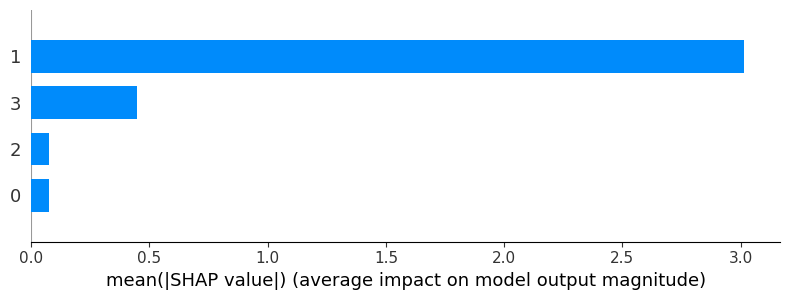

In [19]:
# Initialize an explainer object
explainer = shap.Explainer(best_clf, X_train_pca_df)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_pca_df)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test_pca_df, plot_type="bar")

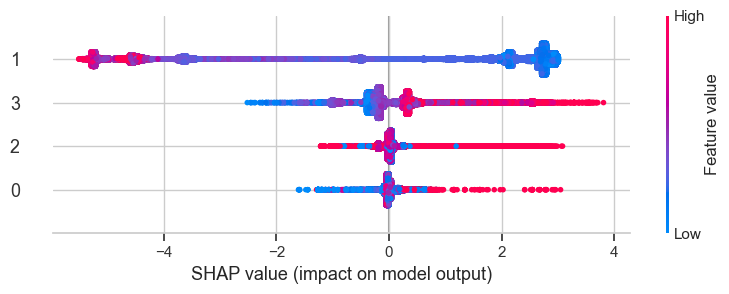

In [32]:
shap.summary_plot(shap_values, X_test_pca_df)

In [33]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test_pca_df.iloc[0])

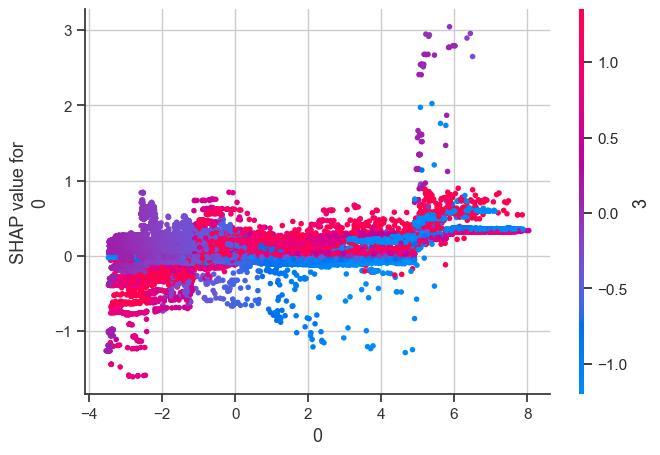

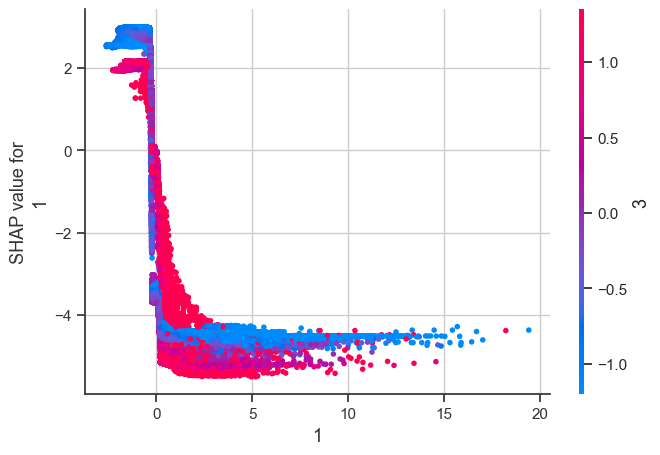

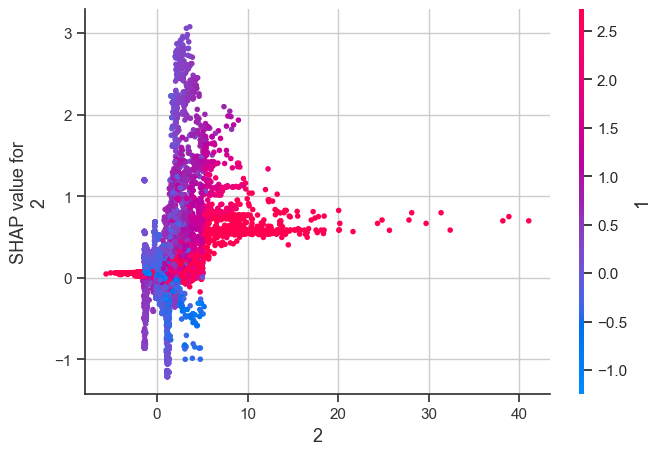

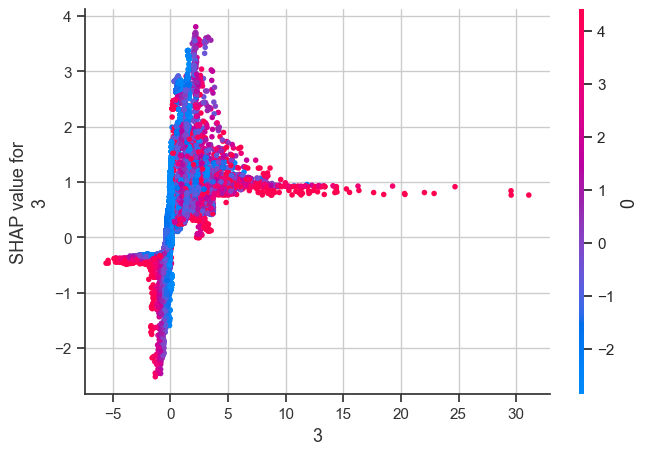

In [41]:
shap.dependence_plot(0, shap_values, X_test_pca_df)
shap.dependence_plot(1, shap_values, X_test_pca_df)
shap.dependence_plot(2, shap_values, X_test_pca_df)
shap.dependence_plot(3, shap_values, X_test_pca_df)